In [1]:
import json
import os
import copy
from typing import Optional
from typing import Tuple
from typing import List
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
import seaborn as sns
sns.set()
from tqdm.notebook import tqdm
from pathlib import Path
import models
import data
import viz
import utils
import latent_dp
from classifier import Classifier

In [2]:
def calc_uncert(p_hat: torch.Tensor) -> Tuple[torch.Tensor, ...]:
    aleatoric = torch.mean(p_hat*(1-p_hat), dim=0)
    epistemic = torch.mean(p_hat**2, dim=0) - torch.mean(p_hat, dim=0)**2
    uncert = aleatoric + epistemic
    return uncert, aleatoric, epistemic

def eval_classifier(exp_name: str, 
                    mc_iter: int = 25,
                    data_type: str = "gt",
                    data_path : Optional[str] = None,
                    dp_sgd: bool = False) -> Tuple[np.ndarray, ...]:
    mean_accs = []
    uncerts_per_class = []
    epsilons = ["no_dp", 0.5, 0.8, 1.0, 2.0, 3.0, 6.0]
    for epsilon in tqdm(epsilons, desc="epsilons"):
        if not dp_sgd:
            cls_path = f"./experiments/{exp_name}/classifier/{epsilon}"
        else:
            cls_path = f"./experiments/{exp_name}/classifier/dp_sgd/{epsilon}"
        timestamps = os.listdir(cls_path)

        mean_accs_pe = []
        uncerts_per_class_pe = []
        
        for ts in tqdm(timestamps, desc="timestamps", leave=False):
            with open(f"{cls_path}/{ts}/summary.json", 'r') as f:
                config = json.load(f)

            img_dims = getattr(data, f"{config['dataset']}_img_dims")
            n_classes = getattr(data, f"{config['dataset']}_n_classes")
            batch_size = config["batch_size"]
            
            if data_type == "dp" and epsilon != "no_dp":
                t = getattr(data, f"{config['dataset']}_transform")
                test_data = torchvision.datasets.ImageFolder(f"{data_path}/{epsilon}", transform=t)
            else:
                test_data = getattr(data, f"{config['dataset']}_test_data")(f"/mnt/ssd/data/{config['dataset']}")
            data_loader  = torch.utils.data.DataLoader(test_data, 
                                                       batch_size=batch_size, 
                                                       shuffle=True, 
                                                       num_workers=4, 
                                                       pin_memory=True, 
                                                       drop_last=True)

            classifier = Classifier(img_dims=img_dims,
                                    n_classes=n_classes,
                                    depth=config["depth"],
                                    dropout=config["dropout"],
                                    dp_sgd=dp_sgd if epsilon != "no_dp" else False).cuda()
            checkpoint = torch.load(f"{cls_path}/{ts}/checkpoint.pt")
            try:
                classifier.load_state_dict(checkpoint)
            except RuntimeError:
                classifier.load_state_dict({'.'.join(key.split('.')[1:]): value for key, value in checkpoint.items()})

            accs, _vars = [], []
            uncerts = []
            with torch.no_grad():
                for x, y in tqdm(data_loader, leave=False):
                    x, y = x.cuda(), y.cuda()
                    mc_preds = torch.cat([torch.softmax(classifier(x), dim=-1)[None] for _ in range(mc_iter)], dim=0)
                    uncert, ale, epi = calc_uncert(mc_preds)
                    uncerts.append(uncert)
                    pred = mc_preds.mean(dim=0)
                    acc = (torch.argmax(pred, dim=1) == y).sum() / y.size(0)
                    accs.append(acc.cpu().item())
                    _vars.append(mc_preds.var(dim=0))
            mean_accs_pe.append(np.mean(accs))

            uncerts = torch.cat(uncerts, dim=0)
            u_per_class = uncerts.mean(dim=0)
            uncerts_per_class_pe.append(u_per_class.cpu().tolist())
        mean_accs.append(mean_accs_pe)
        uncerts_per_class.append(uncerts_per_class_pe)
    
    return np.array(mean_accs), np.array(uncerts_per_class)

In [3]:
mean_accs_mnist, uncert_per_class_mnist = eval_classifier("mnist_conv_cond", mc_iter=5, data_type="dp", data_path="/mnt/ssd/data/priv_mnist_test")

epsilons:   0%|          | 0/7 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [4]:
mean_accs_chest_xray, uncert_per_class_chest_xray = eval_classifier("chest_xray_conv_cond", mc_iter=5, data_type="dp", data_path="/mnt/ssd/data/priv_chest_xray_test")

epsilons:   0%|          | 0/7 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [5]:
mean_accs_oct, uncert_per_class_oct = eval_classifier("oct_conv_cond", mc_iter=5, data_type="dp", data_path="/mnt/ssd/data/priv_oct_test")

epsilons:   0%|          | 0/7 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
mean_accs_mnist_gt, uncert_per_class_mnist_gt = eval_classifier("mnist_conv_cond")

epsilons:   0%|          | 0/7 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [7]:
mean_accs_chest_xray_gt, uncert_per_class_chest_xray_gt = eval_classifier("chest_xray_conv_cond", mc_iter=5)

epsilons:   0%|          | 0/7 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
mean_accs_oct_gt, uncert_per_class_oct_gt = eval_classifier("oct_conv_cond", mc_iter=5)

epsilons:   0%|          | 0/7 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [9]:
mean_accs_mnist_dp_sgd, uncert_per_class_mnist_dp_sgd = eval_classifier("mnist_conv_cond", dp_sgd=True)

epsilons:   0%|          | 0/7 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [11]:
mean_accs_chest_xray_dp_sgd, uncert_per_class_chest_xray_dp_sgd = eval_classifier("chest_xray_conv_cond", mc_iter=5, dp_sgd=True)

epsilons:   0%|          | 0/7 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [12]:
mean_accs_oct_dp_sgd, uncert_per_class_oct_dp_sgd = eval_classifier("oct_conv_cond", mc_iter=5, dp_sgd=True)

epsilons:   0%|          | 0/7 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

timestamps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
import seaborn as sns
sns.set()
cp = sns.color_palette()
cp = [cp[0], cp[2], cp[3]]

epsilons = [0.5, 0.8, 1.0, 2.0, 3.0, 6.0]

fig, ax = plt.subplots()

mean_accs = [[mean_accs_mnist, mean_accs_mnist_gt, mean_accs_mnist_dp_sgd], 
             [mean_accs_oct, mean_accs_oct_gt, mean_accs_oct_dp_sgd], 
             [mean_accs_chest_xray, mean_accs_chest_xray_gt, mean_accs_chest_xray_dp_sgd]]  
for i, (accs, ds) in enumerate(zip(mean_accs, ["mnist", "oct", "chest xray"])): #  
    ax.plot([0, 6.0], [np.mean(accs[0][0]), np.mean(accs[0][0])], c=cp[i], linestyle='--')
    ax.plot(epsilons, np.mean(accs[0][1:], axis=1), c=cp[i], linestyle='-', marker='x')#, label=ds) # private
    ax.plot(epsilons, np.mean(accs[1][1:], axis=1), c=cp[i], linestyle='-', alpha=0.7) # public
    ax.plot(epsilons, np.mean(accs[2][1:], axis=1), c=cp[i], linestyle='-', alpha=0.5) # dp sgd
    ax.scatter(epsilons, np.mean(accs[1][1:], axis=1), color=cp[i], marker='^')
    ax.scatter(epsilons, np.mean(accs[2][1:], axis=1), color=cp[i], marker='*')
    ax.plot([0, 1], [-1, -1], c=cp[i], linestyle='-', label=ds)
ax.plot([0, 1], [-1, -1], c=cp[i], linestyle='-', alpha=0, label=" ")
ax.plot([0, 1], [-1, -1], c='black', linestyle='--', label='GT')
ax.plot([0, 1], [-1, -1], c='black', label='private', linestyle='-', marker='x')
ax.plot([0, 1], [-1, -1], c='black', label='public', linestyle='-', marker='^')
ax.plot([0, 1], [-1, -1], c='black', label='DP-SGD', linestyle='-', marker='*')
ax.legend(fontsize=15, loc="lower right", ncol=2)
ax.set_ylabel("Accuracy", fontsize=15)
ax.set_xlabel(r"$\epsilon$", fontsize=20)
ax.set_ylim([0., 1.01])
# ax.set_aspect(5)
fig.tight_layout()
#fig.savefig("./experiments/classifier_with_dp_sgd.pdf", bbox_inches="tight")

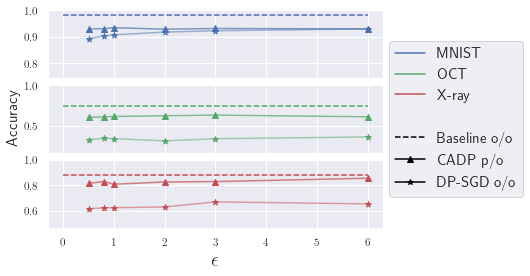

In [17]:
import seaborn as sns
sns.set()
cp = sns.color_palette()
cp = [cp[0], cp[2], cp[3]]

epsilons = [0.5, 0.8, 1.0, 2.0, 3.0, 6.0]
fig, axs = plt.subplots(3)
mean_accs = [[mean_accs_mnist, mean_accs_mnist_gt, mean_accs_mnist_dp_sgd], 
             [mean_accs_oct, mean_accs_oct_gt, mean_accs_oct_dp_sgd], 
             [mean_accs_chest_xray, mean_accs_chest_xray_gt, mean_accs_chest_xray_dp_sgd]] 
for i, (ax, accs, ds) in enumerate(zip(axs, mean_accs, ["MNIST", "OCT", "X-ray"])): #  
    ax.plot([0, 6.0], [np.mean(accs[0][0]), np.mean(accs[0][0])], c=cp[i], linestyle='--')
    #ax.plot(epsilons, np.mean(accs[0][1:], axis=1), c=cp[i], linestyle='-', marker='x')#, label=ds) # private
    ax.plot(epsilons, np.mean(accs[1][1:], axis=1), c=cp[i], linestyle='-', alpha=0.7) # public
    ax.plot(epsilons, np.mean(accs[2][1:], axis=1), c=cp[i], linestyle='-', alpha=0.5)
    ax.scatter(epsilons, np.mean(accs[1][1:], axis=1), color=cp[i], marker='^')
    ax.scatter(epsilons, np.mean(accs[2][1:], axis=1), color=cp[i], marker='*')
    ax.set_ylim([np.min(accs) - 0.15, 1])
    # ax.set_xticks(epsilons[1:])
    if i != 2:
        ax.set_xticklabels([])
    axs[1].plot([0, 1], [-1, -1], c=cp[i], linestyle='-', label=ds)
axs[1].plot([0, 1], [-1, -1], c=cp[i], linestyle='-', alpha=0, label=" ")
axs[1].plot([0, 1], [-1, -1], c='black', linestyle='--', label='Baseline o/o')
#axs[1].plot([0, 1], [-1, -1], c='black', label='CADP p/p', linestyle='-', marker='x')
axs[1].plot([0, 1], [-1, -1], c='black', label='CADP p/o', linestyle='-', marker='^')
axs[1].plot([0, 1], [-1, -1], c='black', label='DP-SGD o/o', linestyle='-', marker='*')
axs[1].set_ylabel("Accuracy", fontsize=15)
axs[-1].set_xlabel(r"$\epsilon$", fontsize=20)
axs[1].legend(fontsize=15, loc="center", bbox_to_anchor=(1.22, .5))
#fig.tight_layout()
fig.subplots_adjust(hspace=0.1)
fig.savefig("./experiments/classifier_3_plots.pdf", bbox_inches="tight")

In [21]:
print(mean_accs_mnist_gt[1:])
print('\n')
print(mean_accs_mnist_dp_sgd[1:])

[[0.92937911]
 [0.93040707]
 [0.93472451]
 [0.92865954]
 [0.93143503]
 [0.92999589]]


[[0.89237253]
 [0.90326891]
 [0.90738076]
 [0.91776316]
 [0.92300576]
 [0.9297903 ]]


In [24]:
np.mean(np.array(mean_accs_oct_gt) - np.array(mean_accs_oct_dp_sgd))

0.23630952380952383

In [25]:
print(mean_accs_oct_gt[1:])
print('\n')
print(mean_accs_oct_dp_sgd[1:])

[[0.60625   ]
 [0.61145833]
 [0.61666667]
 [0.625     ]
 [0.63333333]
 [0.6125    ]]


[[0.33333333]
 [0.34895833]
 [0.34479167]
 [0.31770833]
 [0.34375   ]
 [0.365625  ]]


In [27]:
np.mean(np.array(mean_accs_chest_xray_gt) - np.array(mean_accs_chest_xray_dp_sgd))

0.16517857142857145